In [1]:
!pip install datasets faiss-gpu transformers torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
import faiss
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
fashion_ds = load_dataset("ashraq/fashion-product-images-small", split="train[:12%]")
# why 12%? coz loading the full dataset is taking all the vram of my pc & colab
fashion_ds

README.md:   0%|          | 0.00/867 [00:00<?, ?B/s]

(…)-00000-of-00002-6cff4c59f91661c3.parquet:   0%|          | 0.00/136M [00:00<?, ?B/s]

(…)-00001-of-00002-bb459e5ac5f01e71.parquet:   0%|          | 0.00/135M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/44072 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
    num_rows: 5289
})

#### func to show image

In [4]:
def show_image(sample):
    img = sample["image"]
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{sample['productDisplayName']} ({sample['baseColour']})")
    plt.show()

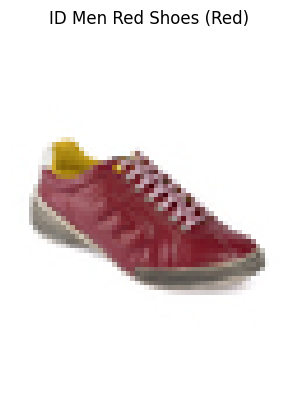

In [5]:
show_image(fashion_ds[69])

#### loading the clip model

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

#### generating image & text embeddings

In [7]:
def encode_images(dataset):
    image_embeddings = []
    for item in dataset:
        image = clip_processor(images=item["image"], return_tensors="pt").to(device)
        with torch.no_grad():
            img_emb = clip_model.get_image_features(**image)
            img_emb /= img_emb.norm(dim=-1, keepdim=True)
        image_embeddings.append(img_emb.cpu().numpy())
    return np.vstack(image_embeddings)

In [8]:
fashion_texts = [
    f"{item['productDisplayName']} {item['articleType']} {item['baseColour']} "
    f"{item['gender']} {item['masterCategory']} {item['subCategory']} {item['usage']}"
    for item in fashion_ds
]
def encode_texts(texts):
    text_inputs = clip_processor(text=texts, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        text_emb = clip_model.get_text_features(**text_inputs)
        text_emb /= text_emb.norm(dim=-1, keepdim=True)
    return text_emb.cpu().numpy()

In [9]:
image_embeddings = encode_images(fashion_ds)

In [10]:
text_embeddings = encode_texts(fashion_texts)

#### making of faiss index

#### concatinating image & text embeddings for hybrid search

In [11]:
hybrid_embeddings = np.hstack([image_embeddings, text_embeddings]).astype("float32")
embedding_dim = hybrid_embeddings.shape[1]

#### building the index

In [12]:
faiss.normalize_L2(hybrid_embeddings)

index = faiss.IndexFlatL2(embedding_dim)
index.add(hybrid_embeddings)

#### function to search

##### here i have included both text and image to search so a text can be passed or even an image can used to search

In [15]:
def search(query, k=5, mode="text"):
    if mode == "text":
        query_embedding = encode_texts([query])
    elif mode == "image":
        query_image = clip_processor(images=query, return_tensors="pt").to(device)
        with torch.no_grad():
            query_embedding = clip_model.get_image_features(**query_image)
            query_embedding /= query_embedding.norm(dim=-1, keepdim=True)
        query_embedding = query_embedding.cpu().numpy()

    query_hybrid = np.hstack([query_embedding, query_embedding]).astype("float32")
    faiss.normalize_L2(query_hybrid)

    distances, indices = index.search(query_hybrid, k)
    print(f"Query: {query}\n")
    for i in range(k):
        sample_index = int(indices[0][i])
        sample = fashion_ds[sample_index]
        print(f"Result {i+1}:")
        print(f"  Product Display Name: {sample['productDisplayName']}")
        print(f"  Article Type: {sample['articleType']}")
        print(f"  Color: {sample['baseColour']}")
        print(f"  Distance: {distances[0][i]:.4f}")
        show_image(sample)

Query: sports cap

Result 1:
  Product Display Name: Probase Men Check Blue Cap
  Article Type: Caps
  Color: Blue
  Distance: 0.9617


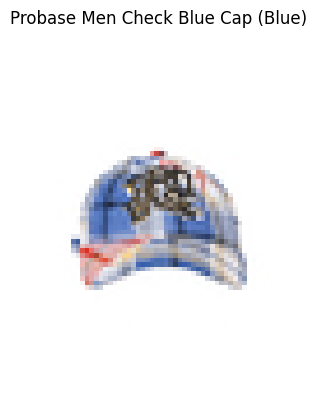

Result 2:
  Product Display Name: Arrow Men White Cap
  Article Type: Caps
  Color: White
  Distance: 1.0118


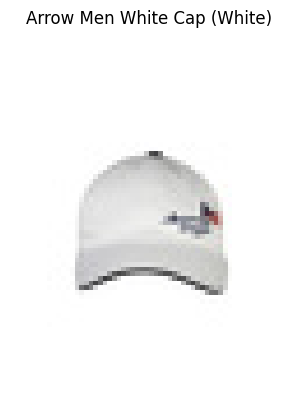

Result 3:
  Product Display Name: Nike Unisex U Black Caps
  Article Type: Caps
  Color: Black
  Distance: 1.0118


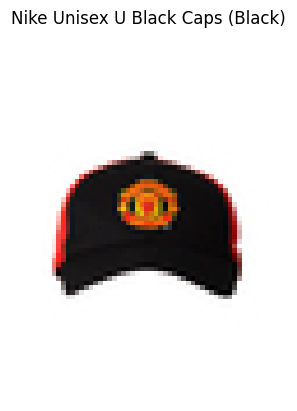

In [17]:
search("sports cap", k=3, mode="text")

Query: formal shoes

Result 1:
  Product Display Name: Red Tape Men Brown Shoes
  Article Type: Formal Shoes
  Color: Brown
  Distance: 0.9380


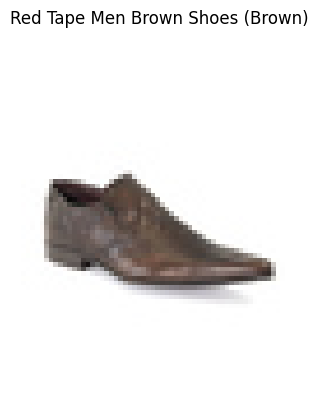

Result 2:
  Product Display Name: Numero Uno Men White Shoes
  Article Type: Casual Shoes
  Color: White
  Distance: 0.9453


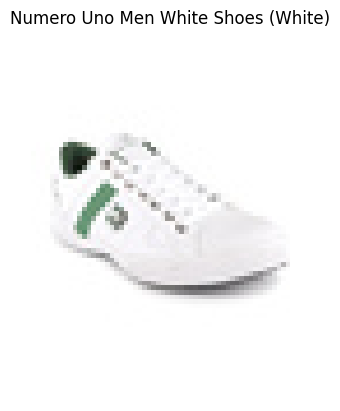

Result 3:
  Product Display Name: Numero Uno Men Black Shoes
  Article Type: Casual Shoes
  Color: Black
  Distance: 0.9461


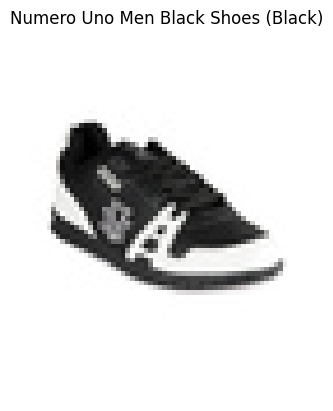

In [18]:
search("formal shoes", k=3, mode="text")